## Imports

In [1]:
import os
os.chdir("..")

In [2]:
import ast
import random
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import pandas as pd
from lightning.fabric import Fabric

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
from dataset import DetectionDataset, collate_fn
from model import YoloV8I, YoloV8I_CONFIGS
from losses import DetectionLoss
from utils.callbacks import EarlyStopping, Checkpoint

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 1. Create DataLoaders

### 1.1 read paths

In [5]:
def get_images_paths(labels, dir_):
    
    images = []
    file_names = [os.path.basename(path).replace(".txt", ".jpg") for path in labels]
    for fname in file_names:
        images.append(os.path.join(dir_, fname))
        
    return images

In [6]:
train_images_dir = os.path.join("data", "bdd100k_images_100k", "bdd100k", "images", "100k", "train")
val_images_dir = os.path.join("data", "bdd100k_images_100k", "bdd100k", "images", "100k", "val")

train_labels = glob(os.path.join("data", "bdd100k_labels_txt", "bdd100k", "labels", "train", "all", "*.txt"))
val_labels = glob(os.path.join("data", "bdd100k_labels_txt", "bdd100k", "labels", "val", "all", "*.txt"))

train_images = get_images_paths(train_labels, train_images_dir)
val_images = get_images_paths(val_labels, val_images_dir)

print(f"Train Count = x: {len(train_images)} | y: {len(train_labels)}")
print(f"Val Count = x: {len(val_images)} | y: {len(val_labels)}")

Train Count = x: 69863 | y: 69863
Val Count = x: 10000 | y: 10000


### 1.2 read mean and std

In [7]:
# read from file
file_path = os.path.join("data", "mean_std_bdd100k.txt")

with open(file_path, mode="r") as f:
    lines = f.readlines()

mean_line = lines[0].split()[1:]
std_line = lines[1].split()[1:]

MEAN = ast.literal_eval(" ".join(mean_line))
STD = ast.literal_eval(" ".join(std_line))

print("Mean:", MEAN)
print("Std:", STD)

Mean: [0.2787, 0.2926, 0.29]
Std: [0.2465, 0.2645, 0.2753]


### 1.3 define necessary variables and transforms

In [8]:
IMAGE_HEIGHT = 480
IMAGE_WIDTH = 640
BATCH_SIZE = 16

CROP_SCALE_HEIGHT = 1.2
CROP_SCALE_WIDTH = 1.5

BBOX_PARAMS = {
    "format": "pascal_voc",
    "min_visibility": 0.3,
    "label_fields": ['category_ids']
}

CLASS_MAP = {
    'traffic-light': 0,
    'traffic-sign': 1,
    'car': 2,
    'person': 3,
    'bus': 4,
    'truck': 5,
    'rider': 6,
    'bike': 7,
    'motor': 8,
    'train': 9,
}

NUM_CLASSES = len(CLASS_MAP) # 10

In [9]:
train_transform = A.Compose(
    [
        A.OneOf(
            [
                A.RandomCrop(
                    width=int(IMAGE_WIDTH * CROP_SCALE_WIDTH),
                    height=int(IMAGE_HEIGHT * CROP_SCALE_HEIGHT),
                p=0.5),
                A.CenterCrop(
                    width=IMAGE_WIDTH,
                    height=IMAGE_HEIGHT,
                p=0.5)
            ],
            p=1.0,
        ),
        A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.01),
    ],
    bbox_params=A.BboxParams(**BBOX_PARAMS),
)

val_transform = A.Compose(
    [
        A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0),
    ],
    bbox_params=A.BboxParams(**BBOX_PARAMS),
)

### 1.4 define datasets and dataloaders

In [10]:
# datasets
train_dataset = DetectionDataset(
    inputs=train_images,
    targets=train_labels,
    transform=train_transform,
    class_map=CLASS_MAP,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    mean=MEAN,
    std=STD,
)

val_dataset = DetectionDataset(
    inputs=val_images,
    targets=val_labels,
    transform=val_transform,
    class_map=CLASS_MAP,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    mean=MEAN,
    std=STD,
)

# dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=0,
    drop_last=False
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=0,
    drop_last=False
)

# INFO
num_train_samples = len(train_dataloader.dataset)
num_val_samples = len(val_dataloader.dataset)

num_train_steps = len(train_dataloader)
num_val_steps = len(val_dataloader)

print(f"Number of samples: Train: {num_train_samples} | Val: {num_val_samples}")
print(f"Number of steps: Train: {num_train_steps} | Val: {num_val_steps}")

Number of samples: Train: 69863 | Val: 10000
Number of steps: Train: 4367 | Val: 625


## 2. Define Fabric and Model

In [11]:
torch.set_float32_matmul_precision('medium')

fabric = Fabric(accelerator="gpu", precision="16-mixed") # precision = "32" / "16-mixed" / "bf16-mixed"

Using 16-bit Automatic Mixed Precision (AMP)


In [12]:
model_type = "m"
model_config = YoloV8I_CONFIGS[model_type]
model_config.num_classes = NUM_CLASSES

model = YoloV8I(model_config)
model

YoloV8I(
  (backbone): Backbone(
    (stem): CBS(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (block1): Sequential(
      (0): CBS(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (1): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU()
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU()
        )
        (m): ModuleList(
 

## 3. Define Loss, optimizer, scheduler, callback, hyperparameters, fabric'ed modules

In [13]:
# hyperparameterss
lr = max_lr = 1e-3
weight_decay = 1e-2
num_epochs = 50

# optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

# fabric'ed
model, optimizer = fabric.setup(model, optimizer)
train_dataloader, val_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader)

# Loss
criterion = DetectionLoss(
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    num_classes=NUM_CLASSES,
    device=fabric.device
)

# scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    div_factor=10,
    pct_start=0.3,
    anneal_strategy='cos'
)


In [14]:
# callbacks
early_stopping = EarlyStopping(patience=5, verbose=True)
checkpoint = Checkpoint(
    root_dir="experiments",
    experiment_name="bdd100k",
    checkpoint_name=f"yolov8I-{model_type}",
    save_model_only=True
)

## 4. Define training loop

In [15]:
def train(mode, epoch, dataloader, num_steps, num_samples):
    
    if mode == "train":
        model.train()
        prefix = ""
    else:
        model.eval()
        prefix = "val_"

    running_losses = {
        "loss": 0.0,
        "box_loss": 0.0,
        "cls_loss": 0.0,
        "dfl_loss": 0.0
    }

    pbar = tqdm(enumerate(dataloader, start=1), total=num_steps, leave=True)
    
    for steps, (inputs, targets) in pbar:
        
        batch_size = inputs.shape[0]

        if mode == "train":
            # forward
            preds = model(inputs)
            loss, losses = criterion(preds, targets)
            box_loss, cls_loss, dfl_loss = losses
            
            # backward
            fabric.backward(loss)
                
            # clip gradients such that their total norm is no bigger than 2.0
            fabric.clip_gradients(model, optimizer, max_norm=2.0, error_if_nonfinite=False)

            # step the optimizer and scheduler
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        elif mode == "val":
            # forward
            with torch.inference_mode():
                _, preds = model(inputs)
                loss, losses = criterion(preds, targets)
                box_loss, cls_loss, dfl_loss = losses

        loss = loss.item()
        box_loss = box_loss.item()
        cls_loss = cls_loss.item()
        dfl_loss = dfl_loss.item()
        
        # update running losses
        running_losses["loss"] += loss * batch_size
        running_losses["box_loss"] += box_loss * batch_size
        running_losses["cls_loss"] += cls_loss * batch_size
        running_losses["dfl_loss"] += dfl_loss * batch_size
        
        if steps == num_steps:
            # last batch; end of epoch
            loss = running_losses["loss"]/ num_samples
            box_loss = running_losses["box_loss"]/ num_samples
            cls_loss = running_losses["cls_loss"]/ num_samples
            dfl_loss = running_losses["dfl_loss"]/ num_samples
        
        # update progress bar
        pbar.set_description(f"Epoch [{epoch}/{num_epochs}]")
        pbar_postfix_dict = {
            f"{prefix}loss": loss,
            f"{prefix}box_loss": box_loss,
            f"{prefix}cls_loss": cls_loss,
            f"{prefix}dfl_loss": dfl_loss,
            "lr": optimizer.param_groups[0]["lr"]
        }
        pbar.set_postfix(pbar_postfix_dict)
        
    return loss, (box_loss, cls_loss, dfl_loss)

## 5. Start Training

In [ ]:
history = {
    "Epoch": [],
    "Train_Loss": [],
    "Train_Box_Loss": [],
    "Train_Cls_Loss": [],
    "Train_Dfl_Loss": [],
    "Val_Loss": [],
    "Val_Box_Loss": [],
    "Val_Cls_Loss": [],
    "Val_Dfl_Loss": [],
    "Lr": []
}

for epoch in range(1, num_epochs + 1):
    train_loss, (train_box_loss, train_cls_loss, train_dfl_loss) = train(
        mode="train",
        epoch=epoch,
        dataloader=train_dataloader,
        num_steps=num_train_steps,
        num_samples=num_train_samples
    )

    val_loss, (val_box_loss, val_cls_loss, val_dfl_loss) = train(
        mode="val",
        epoch=epoch,
        dataloader=val_dataloader,
        num_steps=num_val_steps,
        num_samples=num_val_samples
    )
    
    history["Epoch"].append(epoch)
    history["Train_Loss"].append(train_loss)
    history["Train_Box_Loss"].append(train_box_loss)
    history["Train_Cls_Loss"].append(train_cls_loss)
    history["Train_Dfl_Loss"].append(train_dfl_loss)
    history["Val_Loss"].append(val_loss)
    history["Val_Box_Loss"].append(val_box_loss)
    history["Val_Cls_Loss"].append(val_cls_loss)
    history["Val_Dfl_Loss"].append(val_dfl_loss)
    history["Lr"].append(optimizer.param_groups[0]["lr"])
    
    early_stopping(val_loss)
    if early_stopping.save_current_checkpoint:
        checkpoint(epoch, train_loss, val_loss, model, optimizer, scheduler)

    if early_stopping.early_stop:
        break
        
# save history
columns = list(history.keys())
history_df = pd.DataFrame(history, columns=columns)

history_save_path = os.path.join(checkpoint.ckpt_dir, "history.csv")
history_df.to_csv(history_save_path, encoding='utf-8', header=True, index=False)

In [6]:
history_df.head()

,Epoch,Train_Loss,Train_Box_Loss,Train_Cls_Loss,Train_Dfl_Loss,Val_Loss,Val_Box_Loss,Val_Cls_Loss,Val_Dfl_Loss,Lr
0,1,186.455741,2.538479,181.761518,2.155744,5.067583,1.800893,1.916675,1.350015,0.000110
1,2,4.229276,1.662757,1.247295,1.319224,3.976412,1.605598,1.129342,1.241472,0.000139
2,3,3.855975,1.558263,1.045263,1.252450,3.753544,1.548734,1.005626,1.199184,0.000186
3,4,3.711162,1.512370,0.974424,1.224368,3.615190,1.480316,0.961621,1.173254,0.000249
4,5,3.635459,1.487602,0.938940,1.208917,3.538097,1.463459,0.917858,1.156780,0.000325


## 6. Plots 

In [10]:
def plot(history_df: pd.DataFrame, attribute: str, save_path=None):
    epochs = history_df["Epoch"].tolist()
    train_data = history_df[f"Train_{attribute}"].tolist()
    val_data = history_df[f"Val_{attribute}"].tolist()

    plt.plot(epochs, train_data, 'r', label=f"Train_{attribute}")
    plt.plot(epochs, val_data, 'b', label=f"Val_{attribute}")

    plt.title(attribute)
    plt.legend(loc=0)

    plt.show()
        
plots_save_dir = "plots"
os.makedirs(plots_save_dir, exist_ok=True)

#### 1. Loss

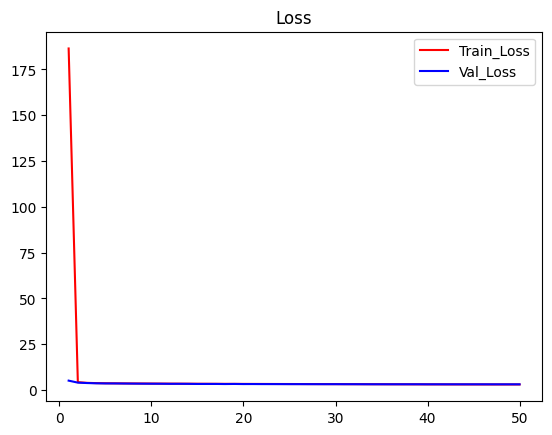

In [11]:
plot(history_df, "Loss"

#### 2. Box_Loss

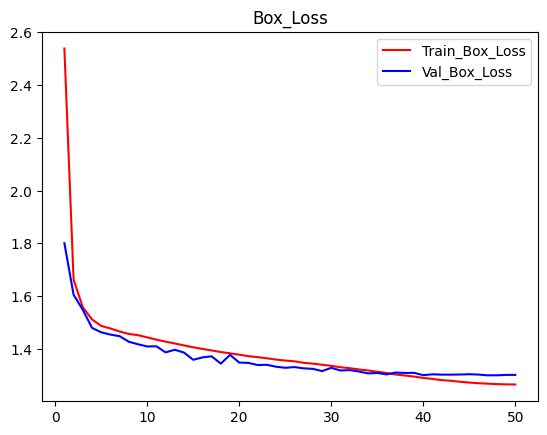

In [12]:
plot(history_df, "Box_Loss")

#### 3. Cls_Loss

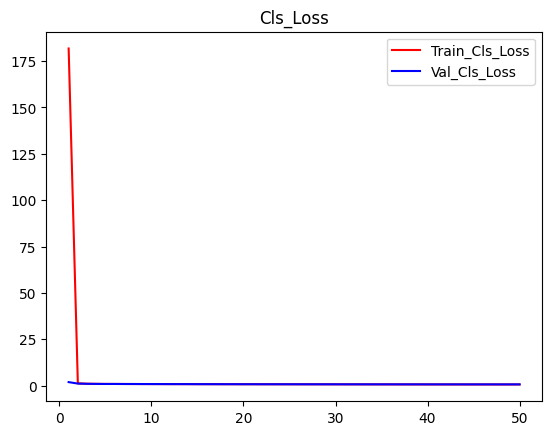

In [20]:
plot(history_df, "Cls_Loss")

#### 4. Dfl_Loss

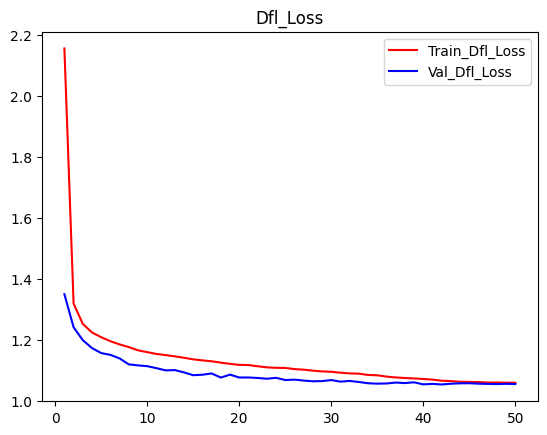

In [21]:
plot(history_df, "Dfl_Loss")